# **Neural Machine Translation**

This tutorial demonstrates how to train a sequence-to-sequence (seq2seq) model for English to Arabic translation using [Transformer](https://arxiv.org/abs/1706.03762)

In [ ]:
%%capture
!pip install "tensorflow-text>=2.11"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_text as tf_text
import tensorflow as tf

from nltk.util import ngrams
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

### Loading the data

In [ ]:
# reading the data
def load_data(path):
  # reading the data
  pairs = pd.read_csv(path).values

  # input and label arrays
  context = pairs[:,0]
  target = pairs[:,1]

  return context, target 

In [ ]:
%%capture
!git clone https://github.com/MarwanMohamed95/English-Arabic-NMT

In [ ]:
path_to_file = '/content/English-Arabic-NMT/translation_train.csv'
context_raw, target_raw = load_data(path_to_file)
print("Number of Samples: ",len(context_raw))

Number of Samples:  23406


In [ ]:
context_raw[-1]

'I am a boy.'

In [ ]:
target_raw[-1]

'أنا ولد.'

In [ ]:
# Creating a tf.data dataset of the strings that shuffles and batches
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (tf.data.Dataset.from_tensor_slices((context_raw[is_train], target_raw[is_train])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE))
val_raw = (tf.data.Dataset.from_tensor_slices((context_raw[~is_train], target_raw[~is_train])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE))

In [ ]:
for en_examples, ar_examples in train_raw.take(1):
  print('> Examples in English:')
  for sp in en_examples[:5]:
    print(sp.numpy().decode('utf-8'))
  print()

  print('> Examples in Arabic:')
  for en in ar_examples[:5]:
    print(en.numpy().decode('utf-8'))

> Examples in English:
My boss is twice as old as I am.
ahmed lababidi on the bus around the island he takes the bus to work but on sundays he has to take a taxi sometimes with quite good korean language proficiency he programs the navigation for the taxi driver credit malte e kollenberg used with pri s permission.
which situation we will see in month there let s hope and pray syria.
It's a rainy day.
the square meter complex that makes up aldeia maracana or maracana village was donated to the indian protection service in from to the buildings served as the headquarters for the museum of the indian however since the change in location of the museum the buildings have been abandoned in indigenous from different ethnicities reoccupied the locale.

> Examples in Arabic:
رئيسي في العمل يكبرني عمراً بمرتين.
احمد لبابيدي على متن الحافلة حول الجزيرة ياخذ الحافلة الى العمل ولكن يوم الاحد عليه ان ياخذ سيارة اجرة في بعض الاحيان مع اتقان اللغة الكورية يعمل على تلقين برنامج الملاحة لسايق سيارة اجر

In [ ]:
# standardizing and processing the text
def english_processing(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)
  # prepend and append START and END tokens to each sentence in the context and target
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
# standardizing and processing the text
def arabic_processing(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ ا-ي.?!,]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)
  # prepend and append START and END tokens to each sentence in the context and target
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
example_text = tf.constant('إن ذلك يغيظني حقاً.')
print(example_text.numpy().decode())
print(arabic_processing(example_text).numpy().decode())

إن ذلك يغيظني حقاً.
[START] ان ذلك يغيظني حقا . [END]


This standardization function will be wrapped up in a tf.keras.layers.TextVectorization layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [ ]:
max_vocab_size = 60000
max_sequence_length = 20

# the English TextVectorization
context_text_processor = tf.keras.layers.TextVectorization(standardize=english_processing, 
                                                           max_tokens=max_vocab_size, 
                                                           output_sequence_length=max_sequence_length)
# This adapt method initializes the layer based on the data.
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# The first 10 words from context the vocabulary
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'the', '.', 'of', 'to', 'in', 'and']

In [ ]:
# the Arabic TextVectorization
target_text_processor = tf.keras.layers.TextVectorization(standardize=arabic_processing, 
                                                          max_tokens=max_vocab_size, 
                                                          output_sequence_length=max_sequence_length)
# This adapt method initializes the layer based on the data.
target_text_processor.adapt(train_raw.map(lambda context, target: target))

# The first 10 words from target the vocabulary
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'في', 'من', '.', 'على', 'ان', 'عن']

In [ ]:
example_tokens = target_text_processor(ar_examples)
example_tokens[:3, :]

<tf.Tensor: shape=(3, 20), dtype=int64, numpy=
array([[    2,  3550,     4,   130, 20862, 11646, 38075,     6,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0],
       [    2,   770,  3209,     7,  3827,  2083,    34,   700,  4166,
         2083,    11,   130,    72,    54,  1178,   155,     8,  4166,
          478,  4667],
       [    2,    37,  2247, 33875,    43,    29,   296,   198,   316,
         3462, 22138,     5,   100,    90,     3,     0,     0,     0,
            0,     0]])>

In [ ]:
target_vocab = np.array(target_text_processor.get_vocabulary())
tokens = target_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] رييسي في العمل يكبرني عمرا بمرتين . [END]           '

In [ ]:
# The process_text function below converts from a (context, target) pair to an ((context, target_in), target_out) pair for training with keras.Model.fit.
# The difference between target_in and target_out is that they are shifted by one step relative to eachother,
# so that at each location the label is the next token.
def process_text(context, target):
  # convert the context strings tensors of token IDs.
  context = context_text_processor(context)
  # convert the target strings tensors of token IDs.
  target = target_text_processor(target)
  # 0-padded target tensors of token IDs except the last token
  targ_in = target[:,:-1]
  # 0-padded target tensors of token IDs shifted by one step relative to targ_in
  targ_out = target[:,1:]
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (context_tokens, target_tokens_in), target_tokens_out in train_ds.take(1):
  print(context_tokens[0].numpy()) 
  print()
  print(target_tokens_in[0].numpy()) 
  print(target_tokens_out[0].numpy())

[    2     4  4121    90   161 14044   115     7  1825     4   405    18
   458     4   147   167   244  3070   147     9]

[    2   104     7   674  5334     8   324 38417  3207   597    58  1731
   128  7393  2020   234  7451   128 25279]
[  104     7   674  5334     8   324 38417  3207   597    58  1731   128
  7393  2020   234  7451   128 25279 38845]


In [ ]:
for (en, ar), ar_labels in train_ds.take(1):
  break

print(en.shape)
print(ar.shape)
print(ar_labels.shape)

(64, 20)
(64, 19)
(64, 19)


### Defining the components

![](https://github.com/MarwanMohamed95/Neural-Machine-Translation-with-Transformer/blob/main/transformer.png?raw=true)

#### The embedding and positional encoding layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic.

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

The formula for calculating the positional encoding (implemented in Python below) is as follows:

$$
\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model} })} \\
\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model} })}
$$

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the position axis.

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

So we use this to create a PositionEmbedding layer that looks-up a token's embedding vector and adds the position vector:

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [ ]:
embed_en = PositionalEmbedding(vocab_size=context_text_processor.vocabulary_size(), d_model=512)
embed_ar = PositionalEmbedding(vocab_size=target_text_processor.vocabulary_size(), d_model=512)

en_emb = embed_en(en)
ar_emb = embed_ar(ar)

#### The base attention layer

Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a layers.MultiHeadAttention, a  layers.LayerNormalization and a layers.Add.

The BaseAttention class is a base class that just contains the component layers. Each use-case will be implemented as a subclass.

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

#### The cross attention layer

This layer connects the encoder and decoder

$$
\begin{aligned}
\text{Attention}(Q, K, V) &= \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)
\end{aligned}
$$

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(ar_emb.shape)
print(sample_ca(ar_emb, en_emb).shape)

(64, 20, 512)
(64, 19, 512)
(64, 19, 512)


#### The global self attention layer

This layer is responsible for processing the context sequence, and propagating information along its length.
The global self attention layer lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_gsa(en_emb).shape)

(64, 20, 512)
(64, 20, 512)


#### The causal self attention layer

This layer does a similar job as the global self attention layer, for the output sequence.
This needs to be handled differently from the encoder's global self attention layer.
Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this efficient, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".
To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention values.

This is taken care of automatically if you pass use_causal_mask = True to the MultiHeadAttention layer when we call it.

The causal mask ensures that each location only has access to the locations that come before it

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(ar_emb.shape)
print(sample_csa(ar_emb).shape)

(64, 19, 512)
(64, 19, 512)


In [ ]:
out1 = sample_csa(embed_ar(ar[:, :3])) 
out2 = sample_csa(embed_ar(ar))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

5.9604645e-07

#### The feed forward network

The transformer includes feed-forward network in both the encoder and decoder

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [ ]:
sample_ffn = FeedForward(512, 2048)

print(ar_emb.shape)
print(sample_ffn(ar_emb).shape)

(64, 19, 512)
(64, 19, 512)


#### The encoder layer

The encoder contains a stack of N encoder layers. Where each EncoderLayer contains a GlobalSelfAttention and FeedForward layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(en_emb.shape)
print(sample_encoder_layer(en_emb).shape)

(64, 20, 512)
(64, 20, 512)


#### The encoder

The encoder consists of:

- A PositionalEmbedding layer at the input.
- A stack of EncoderLayer layers.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [ ]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4, d_model=512, num_heads=8, dff=2048, vocab_size=max_vocab_size)

sample_encoder_output = sample_encoder(en, training=False)

# Print the shape.
print(en.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 20)
(64, 20, 512)


#### The decoder layer

The decoder's layer consists of DecoderLayer containing a CausalSelfAttention, a CrossAttention, and a FeedForward layer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=ar_emb, context=en_emb)

print(ar_emb.shape)
print(en_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 19, 512)
(64, 20, 512)
(64, 19, 512)


#### The decoder
Similar to the Encoder, the Decoder consists of a PositionalEmbedding, and a stack of DecoderLayers

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [ ]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4, d_model=512, num_heads=8, dff=2048, vocab_size=max_vocab_size)

output = sample_decoder(x=en, context=en_emb)

# Print the shapes.
print(ar.shape)
print(ar_emb.shape)
print(output.shape)

(64, 19)
(64, 19, 512)
(64, 20, 512)


#### The Transformer
We now have Encoder and Decoder. To complete the Transformer model, we need to put them together and add a final linear (Dense) layer which converts the resulting vector at each location into output token probabilities.

The output of the decoder is the input to this final linear layer.

A Transformer with one layer in both the Encoder and Decoder looks almost exactly like the model from the RNN+attention tutorial. A multi-layer Transformer has more layers, but is fundamentally doing the same thing.

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
# # Model parameters in original paper
# num_layers = 6
# d_model = 512
# dff = 2048
# num_heads = 8
# dropout_rate = 0.1

# parameters used in this code
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=context_text_processor.vocabulary_size(),
    target_vocab_size=target_text_processor.vocabulary_size(),
    dropout_rate=dropout_rate)

In [ ]:
output = transformer((en, ar))

print(ar.shape)
print(en.shape)
print(output.shape)

(64, 19)
(64, 20)
(64, 19, 45608)


In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 19, 20)


In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  5558912   
                                                                 
 decoder_1 (Decoder)         multiple                  10587648  
                                                                 
 dense_38 (Dense)            multiple                  5883432   
                                                                 
Total params: 22,029,992
Trainable params: 22,029,992
Non-trainable params: 0
_________________________________________________________________


### Training

Optimizer:

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer paper.

$$
\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}
$$

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

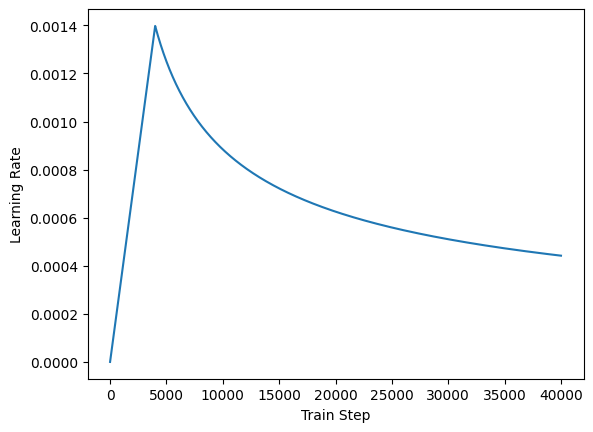

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

#### Defining Loss and Accuracy functions

Applying a padding mask when calculating the loss because the target sequences are padded.

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

In [ ]:
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
transformer.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])

In [ ]:
history = transformer.fit(train_ds, epochs=25, validation_data=val_ds, 
                          # callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]
                          )

Epoch 1/25
294/294 [==============================] - 140s 313ms/step - loss: 10.2095 - masked_accuracy: 0.0612 - val_loss: 9.3646 - val_masked_accuracy: 0.0680
Epoch 2/25
294/294 [==============================] - 58s 195ms/step - loss: 8.4675 - masked_accuracy: 0.0702 - val_loss: 8.2239 - val_masked_accuracy: 0.0925
Epoch 3/25
294/294 [==============================] - 52s 176ms/step - loss: 7.7143 - masked_accuracy: 0.1238 - val_loss: 7.9400 - val_masked_accuracy: 0.1367
Epoch 4/25
294/294 [==============================] - 51s 173ms/step - loss: 7.2257 - masked_accuracy: 0.1600 - val_loss: 7.7803 - val_masked_accuracy: 0.1587
Epoch 5/25
294/294 [==============================] - 49s 167ms/step - loss: 6.7718 - masked_accuracy: 0.1857 - val_loss: 7.5794 - val_masked_accuracy: 0.1844
Epoch 6/25
294/294 [==============================] - 49s 166ms/step - loss: 6.3150 - masked_accuracy: 0.2147 - val_loss: 7.4323 - val_masked_accuracy: 0.2017
Epoch 7/25
294/294 [========================

### Inference

In [ ]:
class Translator(tf.Module):
  def __init__(self, target_text_processor, context_text_processor, transformer):
    self.transformer = transformer
    # target text processor
    self.target_text_processor = target_text_processor
    self.context_text_processor = context_text_processor
    self.vocab_size = self.target_text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(vocabulary = self.target_text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(vocabulary = self.target_text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]', invert=True)
    self.start_token = self.word_to_id('[START]')[tf.newaxis]
    self.end_token = self.word_to_id('[END]')[tf.newaxis]

  
  def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result
    
  def __call__(self, sentence, max_length=128):
    # The input sentence is English, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    # tokenizing the sentence and converting it ti tokens ID
    sentence = self.context_text_processor(sentence)

    encoder_input = sentence

    # output_array which will hold the predicted tokens ID
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, self.start_token)

    for i in tf.range(max_length):
      # getting the predicted tokens so far
      output = tf.transpose(output_array.stack())
      # getting the new prediction
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == self.end_token:
        break

    output = tf.transpose(output_array.stack())
    result = self.tokens_to_text(output)[0]

    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return result, attention_weights

In [ ]:
translator = Translator(target_text_processor, context_text_processor, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

### BLUE SCORE

In [ ]:
### STEP 1: Computing the Brevity Penalty
def brevity_penalty(reference, candidate):
    ref_length = len(reference)
    can_length = len(candidate)

    # Brevity Penalty
    if ref_length > can_length:
        BP = 1
    else:
        penalty = 1 - (ref_length / can_length)
        BP = np.exp(penalty)

    return BP

### STEP 2: Computing the Precision
def clipped_precision(reference, candidate):
score function given a original and a machine translated sentences

    clipped_precision_score = []

    for i in range(1, 5):
        candidate_n_gram = Counter(ngrams(candidate, i))  # counts of tokens for the candidate
        reference_n_gram = Counter(ngrams(reference, i))  # counts of tokens for the reference

        c = sum(reference_n_gram.values())  # sum of the values of the reference the denominator in the precision formula

        for j in reference_n_gram:  # for every n_gram token in the reference
            if j in candidate_n_gram:  # check if it is in the candidate n-gram

                if (reference_n_gram[j] > candidate_n_gram[j]):  # if the count of the reference n-gram is bigger
                    # than the corresponding count in the candidate n-gram
                    reference_n_gram[j] = candidate_n_gram[j]  # then set the count of the reference n-gram to be equal
                    # to the count of the candidate n-gram
            else:
                reference_n_gram[j] = 0  # else reference n-gram = 0

        clipped_precision_score.append(sum(reference_n_gram.values()) / c)

    weights = [0.25] * 4

    s = (w_i * np.log(p_i) for w_i, p_i in zip(weights, clipped_precision_score))
    s = np.exp(np.sum(s))
    return s

### STEP 3: Computing the BLEU score
def bleu_score(reference, candidate):
    BP = brevity_penalty(reference, candidate)
    precision = clipped_precision(reference, candidate)
    return BP * precision

In [ ]:
sentence = "This castle is amazing"
ground_truth = "هذه القلعة مدهشة"

translated_text, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : This castle is amazing
Prediction     : هذه القلعة رايعة .
Ground truth   : هذه القلعة مدهشة


In [ ]:
print("BLUE Score: ",round(bleu_score(ground_truth, translated_text.numpy().decode()) * 100, 1),)

Results reference versus candidate 1 our own code BLEU:  74.5


In [ ]:
sentence = "I'm not thirsty"
ground_truth = "انا لا اشعر بالعطش ."

translated_text, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : I'm not thirsty
Prediction     : لا اشعر بالعطش .
Ground truth   : انا لا اشعر بالعطش .


In [ ]:
print("BLUE Score: ",round(bleu_score(ground_truth, translated_text.numpy().decode()) * 100, 1),)

BLUE Score:  78.3


In [ ]:
sentence = context_raw[1000]
ground_truth = target_raw[1000]

translated_text, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : oman d interviews hani macki an omani documentary photographer.
Prediction     : عمان دي انكليزي يجري مقابلة مع المصور الوثايقي هاني مكي هنا
Ground truth   : عمان دي انكليزي يجري مقابلة مع المصور الوثايقي هاني مكي هنا


In [ ]:
print("BLUE Score: ",round(bleu_score(ground_truth, translated_text.numpy().decode()) * 100, 1),)

BLUE Score:  100.0


### Saving the model

In [ ]:
class Export(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result, attention_weights) = self.translator(sentence, max_length=128)

    return result

In [ ]:
export = Export(translator)

In [ ]:
tf.saved_model.save(export, export_dir='English_Arabic_Translator')

In [ ]:
reloaded = tf.saved_model.load('English_Arabic_Translator')

In [ ]:
reloaded('This castle is amazing').numpy().decode()

'هذه القلعة رايعة .'

In [ ]:
# downloading the model
import shutil
folder_path = '/content/English_Arabic_Translator'

# Creating a zip file of the folder
shutil.make_archive('/content/English_Arabic_Translator', 'zip', folder_path)

# Downloading the zip file
from google.colab import files
files.download('/content/English_Arabic_Translator.zip')

'/content/English_Arabic_Translator.zip'